/home/shibaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/home/shibaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


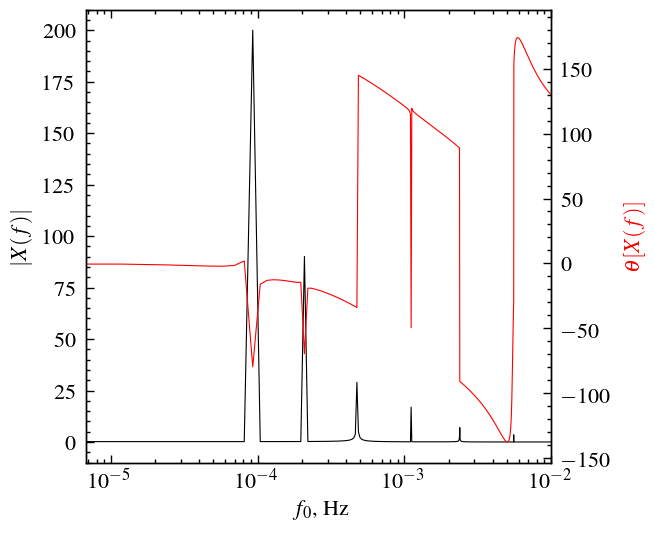

In [3]:
import matplotlib.pyplot as plt
plt.style.use(['science','ieee'])
import numpy as np
import pandas as pd
import scipy.fftpack

import models

def run_rfft_block(x, T=1., plot=True):
    n = int(len(x))
    yf = 2.0/n * np.fft.rfft(x)
    fstep = 1 / n
    frq = np.arange(len(yf)) * fstep
    
    if plot:
        fig, ax = plt.subplots(figsize=(3,3), dpi=200)
        ax.semilogx(frq, np.abs(yf), lw=0.4)
        ax.set_xlim(0, 1e-2)
        ax.set_ylabel(r"$|X(f)|$")
        ax.set_xlabel(r"$f_0$, Hz")
        ax = ax.twinx()
        ax.semilogx(frq, np.rad2deg(np.angle(yf)), "r", lw=0.4)
        ax.set_xlim(0, 1e-2)
        _ = ax.set_ylabel(r"$\theta[X(f)]$", color="r")
    return yf, frq

# setup sample B Field data
Am = np.array([200, 90, 30, 17, 8, 3.5])
Phim = np.array([10, 20, 30, 40, 50, 60])
fm = np.array([0.00009259, 0.00020833, 0.00047619, 0.00111111, 0.00238095, 0.00555555])
t = np.linspace(0,60*60*24,60*60*24)

Bt = np.zeros(len(t))
for m in range(6):
    Bt += Am[m]*np.sin(2*np.pi*fm[m]*t + np.deg2rad(Phim[m]))

def draw_table(qx, f):
    Kfm = qx.calcZ(layer="floor", freqs=f)
    o = pd.DataFrame()
    o["fm (Hz)"], o["Amplitude |Km| (mV/km/nT)"], o["Phase, tm, (deg)"] = fm, np.absolute(Kfm), np.rad2deg(np.angle(Kfm))
    o.index.name = "m"
    return o.copy()

_ = run_rfft_block(Bt)

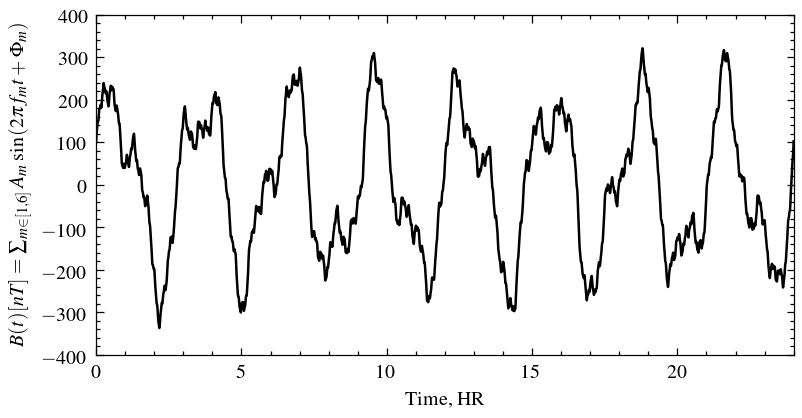

In [6]:
t0 = t/3600.
fig = plt.figure(dpi=180, figsize=(5, 2.5))
ax = fig.add_subplot(111)
ax.plot(t0, Bt, "k")
ax.set_ylabel(r"$B(t)[nT]=\sum_{m\in[1,6]}A_m\sin{(2\pi f_mt+\Phi_m)}$")
ax.set_xlim(0, t0[-1])
ax.set_xlabel("Time, HR")
_ = ax.set_ylim(-400,400)

In [7]:
# Convert uniform Earth model
omu = models.OceanModel()
omu.site.resistivities[:] = 10
ou = draw_table(omu, fm)
print(ou)

# Layered Quebec model
om = models.OceanModel(model_name="DB1")
o = draw_table(om, fm)
print(o)

# Convert uniform Earth model
tfu = omu.get_TFs(freqs=fm)
tfu["Amplitude (mV/km/nT)"], tfu["Phase, tm, (deg)"] = np.absolute(tfu.Ef2Bs), np.rad2deg(np.angle(tfu.Ef2Bs))
tfu = tfu.rename(columns={"freq":"fm (Hz)"}).drop(columns=["Ef2Bs"])
print(tfu)

# Layered Quebec model
tf = om.get_TFs(freqs=fm)
tf["Amplitude (mV/km/nT)"], tf["Phase, tm, (deg)"] = np.absolute(tf.Ef2Bs), np.rad2deg(np.angle(tf.Ef2Bs))
tf = tf.rename(columns={"freq":"fm (Hz)"}).drop(columns=["Ef2Bs"])
print(tf)

    fm (Hz)  Amplitude |Km| (mV/km/nT)  Phase, tm, (deg)
m                                                       
0  0.000093                   0.068040              45.0
1  0.000208                   0.102061              45.0
2  0.000476                   0.154303              45.0
3  0.001111                   0.235702              45.0
4  0.002381                   0.345033              45.0
5  0.005556                   0.527046              45.0
    fm (Hz)  Amplitude |Km| (mV/km/nT)  Phase, tm, (deg)
m                                                       
0  0.000093                   0.218831         77.148399
1  0.000208                   0.448030         73.761223
2  0.000476                   0.868053         67.169259
3  0.001111                   1.539196         62.080708
4  0.002381                   2.593522         60.575720
5  0.005556                   4.662465         54.969926
    fm (Hz)  Amplitude (mV/km/nT)  Phase, tm, (deg)
0  0.000093              0.026889   

In [14]:
from scipy.fft import fft, fftfreq, ifft

def create_fft_frame(signal_a):
    n = int(len(signal_a))
    signal_a_freq = 2.0/n * np.fft.rfft(signal_a)
    fstep = 1 / n
    frq = np.arange(len(signal_a_freq)) * fstep
    frq[0] = frq[1]
    return signal_a_freq, frq

def calculate_electric_field(Bt, ox):
    signal_freq, frq = create_fft_frame(Bt)
    t = ox.get_TFs(freqs=frq)
    Ef2Bs = np.array(t.Ef2Bs)
    Ef = Ef2Bs*signal_freq
    Et = len(Bt)*np.fft.irfft(Ef)/2
    
    dat, fs = [], []
    for f in fm:
        i = np.argmin(abs(f-frq))
        fs.append(frq[i])
        dat.append(Ef[i])
        
    o = pd.DataFrame()
    o["fm (Hz)"], o["Amplitude (mV/km)"], o["Phase, tm, (deg)"] = fs, np.absolute(dat), np.rad2deg(np.angle(dat))
    o.index.name = "m"
    
    return Et, o

def calculate_analytical_et(tx):
    Et = np.zeros(len(t))
    for m in range(6):
        Et += np.absolute(tx["Amplitude (mV/km/nT)"])[m]*Am[m]*np.sin(2*np.pi*fm[m]*t + np.deg2rad(Phim[m]) + 
                                                                      np.rad2deg(tx["Phase, tm, (deg)"])[m])
    Ef, frq = create_fft_frame(Et)
    dat, fs = [], []
    for f in fm:
        i = np.argmin(abs(f-frq))
        dat.append(Ef[i])
        fs.append(frq[i])
        
    o = pd.DataFrame()
    o["fm (Hz)"], o["Amplitude (mV/km)"], o["Phase, tm, (deg)"] = fs, np.absolute(dat), np.rad2deg(np.angle(dat))
    o.index.name = "m"
    
    return Et, o

    fm (Hz)  Amplitude (mV/km)  Phase, tm, (deg)
m                                               
0  0.000093           5.379248        -64.850685
1  0.000208           2.722577        -60.057112
2  0.000475           0.948166        -30.109755
3  0.001111           0.578289        -53.836605
4  0.002384           0.238772       -107.044631
5  0.005556           0.110425        -69.326325
    fm (Hz)  Amplitude (mV/km)  Phase, tm, (deg)
m                                               
0  0.000093           5.375394       -106.398888
1  0.000208           2.712268       -143.436324
2  0.000475           0.948013         48.722765
3  0.001111           0.583249       -115.381174
4  0.002384           0.239921       -153.732638
5  0.005556           0.109944         43.152270


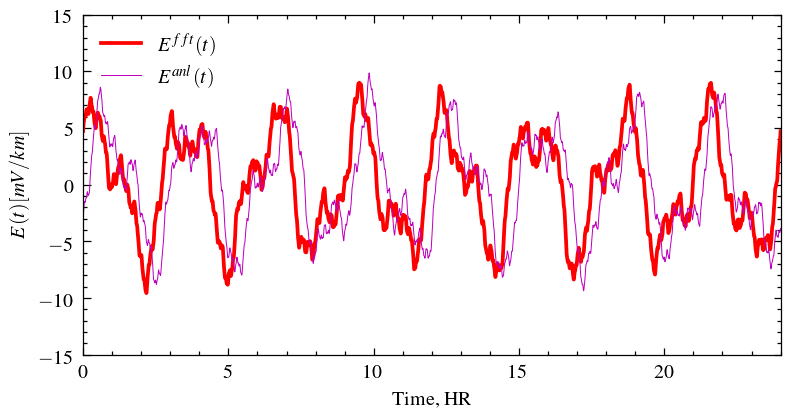

In [15]:
# Convert uniform Earth model
Et_uniform, o_uni = calculate_electric_field(Bt, omu)
Et_analytical_uniform, o_ana_uni = calculate_analytical_et(tfu)
fig = plt.figure(dpi=180, figsize=(5, 2.5))
ax = fig.add_subplot(111)
ax.plot(t0, Et_uniform, "r", lw=1.5, label=r"$E^{fft}(t)$")
ax.set_ylabel(r"$E(t)[mV/km]$")
ax.set_xlim(0, t0[-1])
ax.set_xlabel("Time, HR")
ax.plot(t0, Et_analytical_uniform, "m-", lw=0.4, label=r"$E^{anl}(t)$")
ax.set_ylabel(r"$E(t)[mV/km]$")
ax.legend(loc=2)
ax.set_xlim(0, t0[-1])
_ = ax.set_ylim(-15,15)

print(o_uni)
print(o_ana_uni)